<a href="https://colab.research.google.com/github/arnavjune2/TensorFlow/blob/main/makingNN_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install spicy

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import spicy
from PIL import Image

%matplotlib inline

In [5]:
def load_dataset():
    train_dataset = h5py.File('train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

loading the dataset

In [6]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

cat


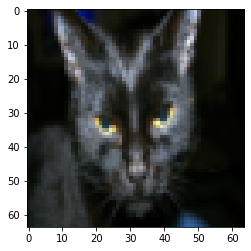

In [7]:
plt.imshow(train_set_x_orig[25])
print(classes[np.squeeze(train_set_y[:,25])].decode('utf-8'))

In [8]:
m_train = train_set_y.shape[1]
m_test = test_set_y.shape[1]
num_px = train_set_x_orig.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


 Reshape the images to a flat vector of shape (height x width x 3, 1)

In [9]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

In [10]:
print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))

train_set_x_flatten shape: (12288, 209)
test_set_x_flatten shape: (12288, 50)


we will now standardize 

In [11]:
train_set_x= train_set_x_flatten/ 225
test_set_x= test_set_x_flatten/ 255

defining the activation function


In [12]:
def sigmoid(z):
  return 1/(1+ np.exp(-z))

creating a function for initializing the weights and bias

In [13]:
def initialize_with_zeros(dim):
  w = np.zeros(shape=(dim,1))
  b = 0

  assert(w.shape == (dim, 1))
  assert(isinstance(b, float) or isinstance(b, int))

  return w, b

now defining a function for **forward   propogation** and for backward propogation



In [15]:
def propagate(w, b, X, Y):
  m = X.shape[1]

  #Forward propogation
  A = sigmoid(np.dot(w.T, X) + b)
  cost = (-1/m) * np.sum(Y * np.log(A) + (1-Y) * (np.log(1-A)))

  #Backward propogation
  dw = (1/m) * np.dot(X, (A-Y).T)
  db = (1/m) * np.sum(A-Y)

  assert(dw.shape == w.shape)
  assert(db.dtype == float)
  cost = np.squeeze(cost)
  assert(cost.shape== ())

  grads = {'dw': dw, 'db': db}

  return grads, cost

Optimization

In [25]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost= False):
  costs = []
  for i in range(num_iterations):
    #cost and gradient calculation
    grads, cost = propagate(w, b, X, Y)

    #Get derivatives
    dw = grads['dw']
    db = grads['db']

    #update rule
    w = w - learning_rate * dw
    b = b - learning_rate * db

    #record costs
    if i % 100 == 0:
      costs.append(cost)

    #print cost every 100 traing examples
    if print_cost and i%100 == 0:
      print('cost after iteration %i: %f' %(i, cost))
    
  params = {'w':w, 'b':b}
  grads = {'dw': dw, 'db': db}

  return params, grads, costs


In [26]:
def predict(w, b, X):
  m = X.shape[1]
  Y_prediction = np.zeros((1, m))
  w = w.reshape(X.shape[0], 1)

  #compute probability vector
  A = sigmoid(np.dot(w.T, X)+b)

  for i in range(A.shape[1]):
    Y_prediction[0,1] = 1 if A[0, i] > 0.5 else 0

  assert(Y_prediction.shape == (1,m))
  return Y_prediction
  

merging all functions into a model

In [27]:
def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    #Initialize parameters with 0s
    w, b = initialize_with_zeros(X_train.shape[0])
    
    #Gradient descent
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    #Retrive parameters w, b from dictionary
    w = parameters['w']
    b = parameters['b']
    
    #Predict test/train set examples
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)
    
    #Print test/train errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))
    
    d = {'costs': costs,
         'Y_prediction_test': Y_prediction_test,
         'Y_prediction_train': Y_prediction_train,
         'w': w,
         'b': b,
         'learning_rate': learning_rate,
         'num_iterations': num_iterations}
    
    return d

In [28]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

cost after iteration 0: 0.693147
cost after iteration 100: 0.666606
cost after iteration 200: 0.561558
cost after iteration 300: 0.462665
cost after iteration 400: 0.369722
cost after iteration 500: 0.287033
cost after iteration 600: 0.238140
cost after iteration 700: 0.219626
cost after iteration 800: 0.204239
cost after iteration 900: 0.190877
cost after iteration 1000: 0.179128
cost after iteration 1100: 0.168703
cost after iteration 1200: 0.159385
cost after iteration 1300: 0.151003
cost after iteration 1400: 0.143425
cost after iteration 1500: 0.136539
cost after iteration 1600: 0.130257
cost after iteration 1700: 0.124503
cost after iteration 1800: 0.119214
cost after iteration 1900: 0.114337
train accuracy: 65.55023923444976 %
test accuracy: 34.0 %


ploting learning rate curve

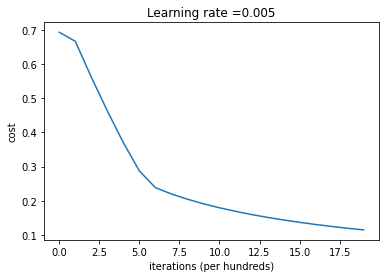

In [29]:
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()